### Week 2
# Eniac Business Insights - Data cleaning

## Import modules and load data

In [481]:
# import libraries
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import re
import seaborn as sns
%matplotlib inline

# load data
def gd_path(file_id):
    """Generate a shareable link from Google Drive file id."""
    return f"https://drive.google.com/uc?export=download&id={file_id}"

# Google Drive file ids
files_id = {
    "products": "1afxwDXfl-7cQ_qLwyDitfcCx3u7WMvkU",
    "orders": "1Vu0q91qZw6lqhIqbjoXYvYAQTmVHh6uZ",
    "orderlines": "1FYhN_2AzTBFuWcfHaRuKcuCE6CWXsWtG", 
    "brands": "1m1ThDDIYRTTii-rqM5SEQjJ8McidJskD"
}

# Read data from Google Drive
products = pd.read_csv(gd_path(files_id["products"]), sep=",")
orders = pd.read_csv(gd_path(files_id["orders"]), sep=",")
orderlines = pd.read_csv(gd_path(files_id["orderlines"]), sep=",")
brands = pd.read_csv(gd_path(files_id["brands"]), sep=",")


## Clean orders

- Remove missing values
- Change dates to datetime format
- Remove all orders that were not completed

In [477]:
# Remove rows with missing values
orders = orders.loc[~orders.total_paid.isna(), :]

# Change dates to datetime format
orders["created_date"] = pd.to_datetime(orders["created_date"])

# Remove all orders that were not completed
orders = orders.loc[orders.state == "Completed", :]


## Clean orderlines

- Change dates to datetime format
- Remove prices with two decimal points
- Convert prices to numerical data format
- Drop product_id

In [482]:
# Change dates to datetime format
orderlines["date"] = pd.to_datetime(orderlines["date"])

# Remove prices with two decimal points
two_dot_order_ids_list = orderlines.loc[orderlines.unit_price.str.contains("\d+\.\d+\.\d+"), "id_order"]
orderlines = orderlines.loc[~orderlines.id_order.isin(two_dot_order_ids_list)]

# Convert prices to numerical data format
orderlines["unit_price"] = pd.to_numeric(orderlines["unit_price"])

# Drop product_id
orderlines = orderlines.drop(columns='product_id')


## Clean products

- Drop duplicates
- Remove/replace missing values
- Fix decimal point problems in prices (and promo_prices)
- Convert prices to numerical data type
- Drop promo prices
- (Fix exponential values in type)

In [483]:
## Drop duplicates
products = products.drop_duplicates()
products = products.drop_duplicates(subset=['sku'])


## Remove/replace missing values
# price
# --> Mostly Celly products
# Could replace missing prices by promo_price assuming that there is only one 
# price but since it's only 0.2% of the data it's probably safer to just remove those rows
products = products.loc[~products.price.isnull(),:]

# type
# --> Mostly (but not only!) Apple iPhones
# Only 0.3% and not clear what to replace with, so drop lines
products = products.loc[~products.type.isnull(),:]

# desc
# Only 7 products --> remove
products = products.loc[~products.desc.isnull(),:]


## Fix double decimal point problem
# Prices: 
# - move the first point one place to the right
# - remove the second point
double_point_idx_prices = products.price.str.contains('\d+\.\d+\.\d+')
products.loc[double_point_idx_prices,'price'] = products.loc[double_point_idx_prices,'price'].str.replace(r'(\d+)\.(\d)(\d+)\.(\d+)', r'\1\2.\3\4', regex=True)


## Fix 3 decimal places problem: Move decimal point one place to the left
# Prices
triple_dec_idx_prices = products.price.str.contains('\d+\.\d{3}$')
products.loc[triple_dec_idx_prices & ~double_point_idx_prices,'price'] = products.loc[triple_dec_idx_prices & ~double_point_idx_prices,'price'].str.replace(r'(\d*)(\d)\.(\d{3})$', r'\1.\2\3', regex=True)


## Convert prices to numerical data type and round to two decimal places
products.loc[:,'price'] = pd.to_numeric(products['price']).round(2)


## Remove promo prices
products = products.drop(columns="promo_price")

## Fix exponential values in type
# ...



## Remove mismatches between orders and orderlines

In [484]:

# Remove orderlines that are not present in orders
orderlines = orderlines.loc[orderlines.id_order.isin(orders.order_id),:]

# Remove orders that are not present in orderlines
orders = orders.loc[orders.order_id.isin(orderlines.id_order),:]

## Exclude orders with unknown products

In [485]:
# 1. Remove orderlines referring to products not listed in the products table
orderlines = orderlines.loc[orderlines.sku.isin(products.sku),:]

# 2. Update orders (remove orders that no longer have orderlines)
orders = orders.loc[orders.order_id.isin(orderlines.id_order),:]

# It might be that some orders only lost part of their orderlines, which means 
# that the total_paid column in orders no longer reflects the total of the 
# listed products in that order

In [486]:
# Check outliers

# Total unit price
orderlines['unit_price_total'] = orderlines.unit_price * orderlines.product_quantity

# Total order price computed from unit_price by grouping order IDs
oltotal = orderlines.groupby('id_order').agg({'unit_price_total': 'sum'})

# Merge with orders table to compute difference in total paid
oltotal_o = oltotal.merge(orders, how='inner', left_on='id_order', right_on='order_id')
oltotal_o['price_diff'] = oltotal_o.total_paid - oltotal_o.unit_price_total

# Detect bad IDs (>50€ difference)
bad_ids = oltotal_o.loc[abs(oltotal_o.price_diff) > 50, 'order_id']

# Exclude corresponding orders
orders = orders.loc[~orders.order_id.isin(bad_ids)]

# Update orderlines
orderlines = orderlines.loc[orderlines.id_order.isin(orders.order_id),:]



## Save cleaned data as csv



In [487]:
# 1. Accessories
accessories = ['11865403', '1298', '12635403', '13835403', '12585395', '1325', '2449', '13615399', '13555403', '1229', '1515', ]

# 2. Hard drives
hard_drives = ['11935397', '1364', '1433', '12215397', '12655397', '57445397']

# 3. Computers
computers = ['1282', '5,74E+15', '1,02E+12', '2158']

# 4. Internet
internet = ['12175397', '1334', '12995397']

# 5. Repair services
repair_services = ['1,44E+11']

# 6. Gadgets
gadgets = ['11905404']

# 7. Tablets
tablets = ['1405']

# 8. Monitors
monitors = ['1296']

# 9. Audio
audio = ['5384', '5398']



## Extra categories
# 11. iPhones
iphone_regex = re.compile(r"Apple iPhone .{1,2} .*", flags=re.IGNORECASE)
iphones = products.loc[products.name.str.contains(iphone_regex, regex=True), "type"].unique().tolist()

# iPads --> goes into tablets
ipad_regex = re.compile(r"^(?!.*\b(Case|Cover)\b)(?=.*\bApple iPad\b).+$", flags=re.IGNORECASE)
ipads = products.loc[products.name.str.contains(ipad_regex, regex=True), "type"].unique().tolist()
tablets += ipads 

# Keyboards and Mice
keyboard_mice_regex = re.compile(r".*(keyboard|mouse).*", flags=re.IGNORECASE)
keyboard_mice = products.loc[products.name.str.contains(keyboard_mice_regex, regex=True), "type"].unique().tolist()
accessories += keyboard_mice


In [488]:
products["category"] = ""

products.loc[products["type"].isin(accessories), "category"] = "Accessories"
products.loc[products["type"].isin(hard_drives), "category"] = "Hard drives"
products.loc[products["type"].isin(computers), "category"] = "Computers"
products.loc[products["type"].isin(internet), "category"] = "Internet"
products.loc[products["type"].isin(repair_services), "category"] = "Repair services"
products.loc[products["type"].isin(gadgets), "category"] = "Gadgets"
products.loc[products["type"].isin(tablets), "category"] = "Tablets"
products.loc[products["type"].isin(monitors), "category"] = "Monitors"
products.loc[products["type"].isin(audio), "category"] = "Audio"
products.loc[products["type"].isin(iphones), "category"] = "iPhones"

products.loc[products["category"] == "", "category"] = "Other"

products["category"].value_counts()


iPhones        2119
Accessories    1692
Other          1531
Hard drives    1428
Internet       1318
Computers       887
Tablets         501
Gadgets         472
Audio           341
Monitors        188
Name: category, dtype: int64

In [489]:
products["state"] = "New"

recycling_regex = re.compile(r"^(?=.*\b(Open|Like new|refurbished|reconditioned|second hand)\b).+$", flags=re.IGNORECASE)
products.loc[products.name.str.contains(recycling_regex, regex=True) | products.desc.str.contains(recycling_regex, regex=True), "state"] = "Refurbished"

products["state"].value_counts()

New            8798
Refurbished    1679
Name: state, dtype: int64

In [490]:
products["price category"] = pd.cut(products.price, [0, 100, 1000, 20000], labels=["Low", "Medium", "High"])

products["price category"].value_counts()

Low       5246
Medium    3354
High      1877
Name: price category, dtype: int64

In [ ]:
products

In [ ]:
orders

In [ ]:
orderlines

In [491]:
orderlines = orderlines.rename(columns={'id_order':'order_id'})

In [492]:
ordm = orderlines.merge(orders, how = 'inner', on = 'order_id')

In [493]:
ordlp = ordm.merge(products, how = 'inner', on = 'sku')

In [495]:
ordlp.head(2)

,id,order_id,product_quantity,sku,unit_price,date,unit_price_total,created_date,total_paid,state_x,name,desc,price,in_stock,type,category,state_y,price category,brand
0,1119109,299539,1,OTT0133,18.99,2017-01-01 00:07:19,18.99,2017-01-01 00:07:19,18.99,Shopping Basket,Otterbox iPhone Case Symmetry 2.0 SE / 5s / 5 Black,resistant cover and thin beveled edges for iPhone SE / 5s / 5,34.99,0,11865403,iPhones,New,Low,OTT
1,1119236,299603,1,OTT0133,18.99,2017-01-01 10:18:53,18.99,2017-01-01 10:18:53,18.99,Shopping Basket,Otterbox iPhone Case Symmetry 2.0 SE / 5s / 5 Black,resistant cover and thin beveled edges for iPhone SE / 5s / 5,34.99,0,11865403,iPhones,New,Low,OTT


In [494]:
ordlp['brand'] = ordlp['sku'].str[:3]

In [ ]:
ordlp

In [496]:
ordlp.groupby("type").count().nlargest(30, "sku")

,id,order_id,product_quantity,sku,unit_price,date,unit_price_total,created_date,total_paid,state_x,name,desc,price,in_stock,category,state_y,price category,brand
type,,,,,,,,,,,,,,,,,,
11865403,18072,18072,18072,18072,18072,18072,18072,18072,18070,18072,18072,18072,18072,18072,18072,18072,18072,18072
11935397,13663,13663,13663,13663,13663,13663,13663,13663,13662,13663,13663,13663,13663,13663,13663,13663,13663,13663
11905404,12528,12528,12528,12528,12528,12528,12528,12528,12528,12528,12528,12528,12528,12528,12528,12528,12528,12528
1364,10891,10891,10891,10891,10891,10891,10891,10891,10891,10891,10891,10891,10891,10891,10891,10891,10891,10891
5384,8329,8329,8329,8329,8329,8329,8329,8329,8328,8329,8329,8329,8329,8329,8329,8329,8329,8329
12215397,8256,8256,8256,8256,8256,8256,8256,8256,8256,8256,8256,8256,8256,8256,8256,8256,8256,8256
12655397,7089,7089,7089,7089,7089,7089,7089,7089,7089,7089,7089,7089,7089,7089,7089,7089,7089,7089
1296,6292,6292,6292,6292,6292,6292,6292,6292,6292,6292,6292,6292,6292,6292,6292,6292,6292,6292
1231,5869,5869,5869,5869,5869,5869,5869,5869,5869,5869,5869,5869,5869,5869,5869,5869,5869,5869


In [ ]:
ordlp

In [497]:
pd.set_option('display.max_rows', 100)

In [ ]:
ordlp

In [498]:
ordlp.loc[ordlp["name"].str.contains('open -', case = False), 'category'] += ', B-stock'
ordlp.loc[ordlp["name"].str.contains('like new -', case = False), 'category'] += ', refurbished/2ndhand'

In [499]:
ordlp.loc[ordlp["name"].str.contains('open -', case = False), :].groupby(['brand', 'desc']).agg({'unit_price' : 'mean'})

unit_price
brand desc                                                                                                           
8MO   Micro SD card adapter for MacBook Air 13-inch                                                          12.96000
      Refurbished adapter Micro SD card for MacBook Pro Retina 15-inch Mid 2012 / Early 2013                 12.85000
ADN   Bluetooth digital pen tip 19mm for iPad                                                                61.30800
      Bluetooth digital pen tip 19mm for iPhone and iPad                                                     63.56000
      Egonómico pointer lightweight design magnet for iPhone                                                 27.96000
...                                                                                                               ...
XDO   protection and shock absorption in triplicate with military grade                                      12.61000
ZAG   Case reconditioned keyboard and adjustable position for 97-inch model Cases 2017                       25.47000
      Cover with ultra resistant reconditioned and backlit keys keyboard cases Pro 129 inches                37.02125
      Reconditioned Case with Bluetooth Keyboard for iPad Air 2 Spanish.                                     19.85625
      skinny sleeve with bluetooth keyboard and adjustable design for iPad Air / Air 2 / iPad Pro 97-inch    39.77000

[828 rows x 1 columns]

In [500]:
ordlp.loc[~ordlp["name"].str.contains('open -', case = False), :].groupby(['brand', 'desc']).agg({'unit_price' : 'mean'})

unit_price
brand desc                                                                                                            
8MO   Micro SD card adapter for MacBook Air 13-inch                                                          21.369310
      Micro SD card adapter for MacBook Pro Retina 13 inches                                                 21.723333
      Micro SD card adapter for MacBook Pro Retina 15-inch Late 2013 / Mid 2015                              19.759722
      Micro SD card adapter for MacBook Pro Retina 15-inch Mid 2012 / Early 2013                             18.181111
ACM   Neoprene Sleeve for MacBook Air / Pro 13-inch.                                                         23.990000
...                                                                                                                ...
ZAG   skinny sleeve with bluetooth keyboard and adjustable design for iPad Air / Air 2 / iPad / iPad Pr...   54.504308
      thin bluetooth Backlit Keyboard Folio for iPad Pro 97                                                  79.347143
ZEP   3D swing analyzer via App for iPhone iPad and iPod Touch.                                             137.118000
      Beat tennis analyzer via 3D App for iPhone iPad and iPod Touch.                                       104.120000
par   Drone cuadricóptero HD video recording autonomous 12â "for iPhone iPad and iPod Touch                 224.158333

[4335 rows x 1 columns]

In [501]:
cat_counts = ordlp.groupby('brand').agg({'category' : 'count'})


In [503]:
cat_counts

,category
brand,
8MO,136
ACM,3
ADN,708
ADO,11
AII,8
...,...
XRI,55
XTO,18
ZAG,2728


<Axes: ylabel='None'>

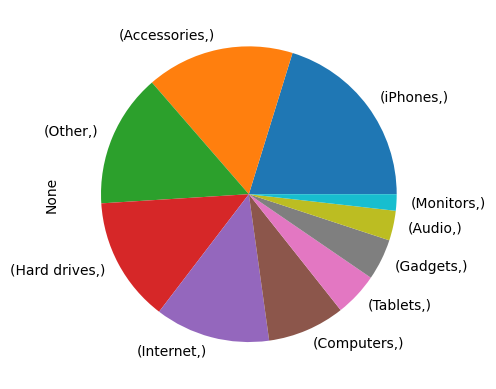

In [505]:
cat_counts = products[["category"]].value_counts()
cat_counts.plot.pie()

In [508]:
ordlp["month"] = ordlp["date"].dt.month
ordlp["year"] = ordlp["date"].dt.year
ordlp.head(1)

,id,order_id,product_quantity,sku,unit_price,date,unit_price_total,created_date,total_paid,state_x,...,desc,price,in_stock,type,category,state_y,price category,brand,month,year
0,1119109,299539,1,OTT0133,18.99,2017-01-01 00:07:19,18.99,2017-01-01 00:07:19,18.99,Shopping Basket,...,resistant cover and thin beveled edges for iPhone SE / 5s / 5,34.99,0,11865403,iPhones,New,Low,OTT,1,2017


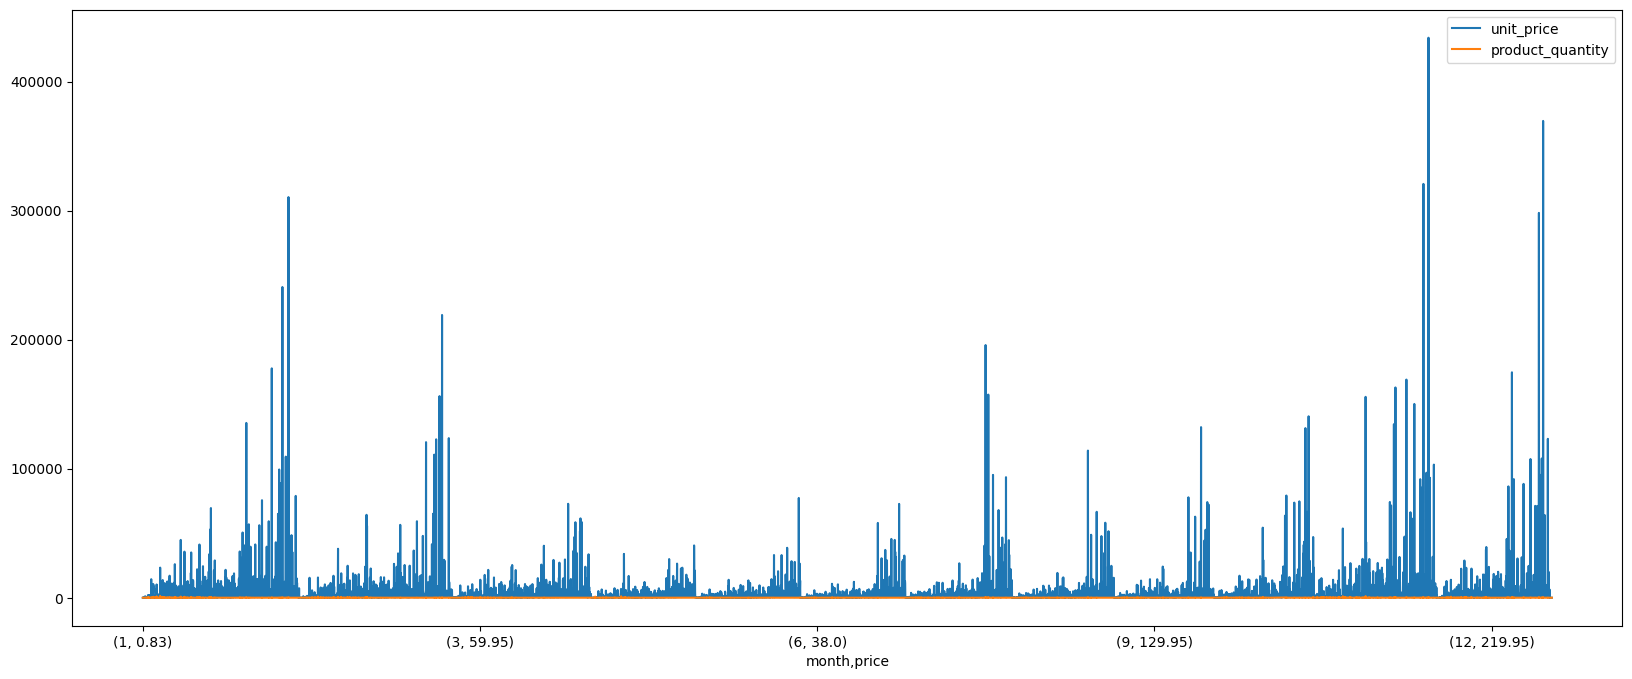

In [509]:
freqd = ordlp.loc[ordlp['category'].isin(['iPhones','Accesories', 'Other', 'Hard drives', 'Computers', 'Internet', 'Tablets', 'Monitors', 'Audio', 'Gadgets'])][['sku', 'price', 'unit_price', 'product_quantity', 'month']].groupby(['month', 'price']).agg({'unit_price' : 'sum', 'product_quantity' : 'sum'}).plot.line(figsize=(20,8))

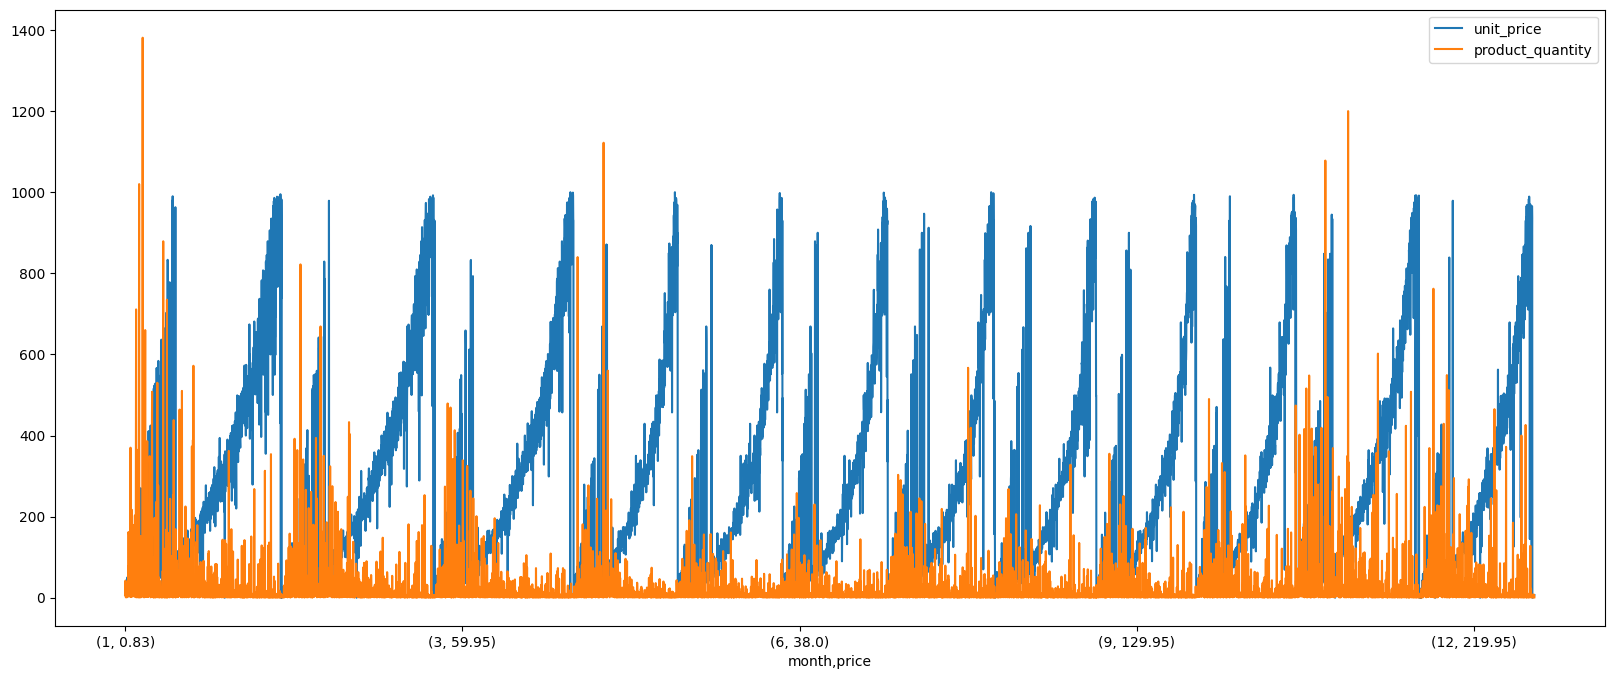

In [510]:
freqd = ordlp.loc[ordlp['category'].isin(['iPhones','Accesories', 'Other', 'Hard drives', 'Computers', 'Internet', 'Tablets', 'Monitors', 'Audio', 'Gadgets'])][['sku', 'price', 'unit_price', 'product_quantity', 'month']].groupby(['month', 'price']).agg({'unit_price' : 'mean', 'product_quantity' : 'sum'}).plot.line(figsize=(20,8))

In [511]:
plot = ordlp.groupby(['year', 'month', 'brand', 'category']).agg({'unit_price':'sum'}).sort_values(by = 'unit_price', ascending = False)

In [512]:
ordlp.groupby(['year', 'month', 'brand', 'category']).agg({'unit_price':'sum'}).sort_values(by = 'unit_price', ascending = False)

unit_price
year month brand category                        
2017 11    APP   iPhones               1589290.33
     12    APP   iPhones               1274161.55
2018 1     APP   iPhones               1033688.94
     2     APP   iPhones                708419.77
2017 10    APP   iPhones                687958.79
...                                           ...
     4     BOO   Accessories, B-stock        2.99
     7     MOX   iPhones, B-stock            2.54
     1     SHE   iPhones, B-stock            2.31
2018 1     IKM   Audio                       0.00
2017 12    WAC   Tablets, B-stock            0.00

[4819 rows x 1 columns]

In [513]:
(
    ordlp
    .groupby(["sku"])
    .agg({"product_quantity": ["sum"], "unit_price": ["sum"]})
    .nlargest(10, ("product_quantity", "sum"))
)

,product_quantity,unit_price
,sum,sum
sku,,
APP1190,5555,239979.83
APP0698,2335,16317.81
WDT0183,1795,153031.20
APP1922,1661,252611.59
APP0927,1616,23291.05
SAM0074,1340,191503.63
APP1970,1181,365150.88
APP1221,1129,117397.50


In [514]:
ordlp.loc[ordlp['category'].isin(['iPhones','Accesories', 'Other', 'Hard drives', 'Computers', 'Internet', 'Tablets', 'Monitors', 'Audio', 'Gadgets'])][['brand', 'category', 'price', 'unit_price', 'year', 'product_quantity', 'month']].groupby(['brand', 'category', 'year', 'month', 'price']).agg({'unit_price' : 'mean', 'product_quantity' : 'sum'})

unit_price  product_quantity
brand category year month price                               
ADO   Other    2017 1     290.25      289.99                 1
                    3     290.25      289.99                 1
                          435.45      459.99                 2
                    4     290.25      289.99                 1
                    5     290.25      289.99                 2
...                                      ...               ...
par   Gadgets  2017 5     349.00      269.99                 1
                    7     349.00      269.99                 2
                    11    349.00      197.99                 2
                    12    349.00      216.99                 1
               2018 1     349.00      217.24                 5

[17016 rows x 2 columns]

In [515]:
pd.set_option('display.max_rows', 1000)
pd.set_option("display.max_colwidth", 100)
ordlp['discount'] = ordlp['price'] - ordlp['unit_price']

In [516]:
(
    ordlp
    .groupby(['category', 'price category', "sku",'year', 'month'])
    .agg({"product_quantity": ["sum"], "unit_price": ["sum"], 'discount' : 'sum'})
    .nlargest(100, ("unit_price", "sum")).head(10)
)

product_quantity unit_price  \
                                                        sum        sum   
category price category sku     year month                               
iPhones  Medium         APP2485 2017 11                 238  203363.65   
                                     12                 190  167643.51   
                                2018 1                  178  157780.86   
                        APP2446 2017 7                  419  157436.35   
                        APP2477 2017 11                 206  153211.84   
                        APP2483 2017 11                 164  140246.91   
                        APP2477 2017 12                 179  131497.36   
                        APP2483 2017 12                 146  124224.76   
Other    High           APP2072 2018 2                  128  123695.66   
                                2017 12                 128  123152.81   

                                            discount  
                                                 sum  
category price category sku     year month            
iPhones  Medium         APP2485 2017 11      8006.35  
                                     12      5128.49  
                                2018 1       5801.14  
                        APP2446 2017 7      24542.30  
                        APP2477 2017 11      5352.16  
                        APP2483 2017 11      4955.09  
                        APP2477 2017 12      5223.64  
                        APP2483 2017 12      4435.24  
Other    High           APP2072 2018 2      17819.86  
                                2017 12     17257.12

In [517]:
products.loc[products['sku']== 'APP2072']

,sku,name,desc,price,in_stock,type,category,state,price category
16720,APP2072,"Apple MacBook Air 13 ""Core i5 18GHz | 8GB RAM | 128GB SSD",laptop MacBook Air 13 inch i5 18GHz 8GB RAM and 128GB SSD,1105.59,1,"2,17E+11",Other,New,High


In [518]:
products.loc[products['type'] == '2,17E+11']

,sku,name,desc,price,in_stock,type,category,state,price category
2574,APP0995,"Apple MacBook Pro Retina 15 ""i7 22 Ghz | RAM 16GB | 256GB PCIe SSD",New MacBook Pro 15-inch Retina screen Core i7 16GB RAM 256GB 22GHz (MJLQ2Y / A).,2255.59,1,"2,17E+11",Other,New,High
2580,APP1005,"Apple MacBook Pro Retina 15 ""i7 25 Ghz | RAM 16GB | 256GB Flash",New MacBook Pro 15-inch Retina screen Core i7 16GB RAM 256GB 25Ghz (MJLQ2Y / A).,2369.00,0,"2,17E+11",Other,New,High
15952,AP20085,"Like new - Apple Macbook Air 13 ""i5 16GHz | 8GB RAM | 256GB Flash",Computer Refurbished MacBook Air 13-inch i5 16GHz | 8GB RAM | 256GB Flash,1349.00,0,"2,17E+11",Other,Refurbished,High
15953,AP20079,"Like new - Apple MacBook Pro Retina 13 ""i5 27 GHz | 8GB RAM | 128GB Flash",Computer Refurbished MacBook Pro 13-inch i5 27GHz | 8GB RAM | 128GB Flash,1499.00,0,"2,17E+11",Other,Refurbished,High
15957,AP20081,"Like new - Apple MacBook Pro Retina 15 ""i7 22 GHz | RAM 16GB | 256GB Flash",Computer MacBook Pro 15 inch i7 refitted 22GHz | 16GB RAM | 256GB Flash,2249.00,0,"2,17E+11",Other,Refurbished,High
15959,AP20084,"Like new - Apple Macbook Air 13 ""i5 16GHz | 8GB RAM | 128GB Flash",Computer Refurbished MacBook Air 13-inch i5 16GHz | 8GB RAM | 128GB Flash,1099.00,0,"2,17E+11",Other,Refurbished,High
16720,APP2072,"Apple MacBook Air 13 ""Core i5 18GHz | 8GB RAM | 128GB SSD",laptop MacBook Air 13 inch i5 18GHz 8GB RAM and 128GB SSD,1105.59,1,"2,17E+11",Other,New,High
16722,APP2253,"Apple MacBook Air 13 ""Core i5 18GHz | 8GB RAM | 256GB SSD",laptop MacBook Air 13 inch i5 18GHz 8GB RAM and 256GB SSD,1349.00,0,"2,17E+11",Other,New,High
16724,APP2257,"Apple MacBook Air 13 ""Core i7 22GHz | 8GB | 256GB SSD",laptop MacBook Air 13 inch with 8GB RAM 22GHz i7 and 256GB SSD,1779.00,0,"2,17E+11",Other,New,High
16726,APP2258,"Apple MacBook Air 13 ""Core i5 18GHz | 8GB | 256GB SSD",laptop MacBook Air 13 inch i5 18GHz 8GB RAM and 256GB SSD,1599.00,0,"2,17E+11",Other,New,High


In [519]:
(
    ordlp
    .groupby(['brand', 'price category', 'year', 'month'])
    .agg({"product_quantity": ["sum"], "unit_price": ["sum"], 'discount' : 'sum'})
    .nlargest(100, ("unit_price", "sum")).head(10)
)

product_quantity  unit_price   discount
                                             sum         sum        sum
brand price category year month                                        
APP   Medium         2017 11                5178  2345485.39  153249.73
                          12                4143  1976700.83  114196.04
                     2018 1                 3067  1613442.56  107941.88
                          2                 2060  1056283.30   50557.72
                     2017 10                2075   986279.68   42119.51
                          7                 2247   960782.52   65991.05
                          9                 1570   792078.49   28888.35
                          8                 1451   634672.86   51003.50
                          6                 1050   504520.11     939.97
                     2018 3                 1094   499766.43   27367.61

In [520]:
brands.loc[brands['short'] == 'LAC']

,short,long
75,LAC,LaCie


In [521]:
import seaborn as sns

In [522]:
ordlp['discount'] == ordlp['unit_price'] / ordlp['price'] * 100

0         False
1         False
2         False
3         False
4         False
          ...  
214322    False
214323    False
214324    False
214325    False
214326    False
Length: 214327, dtype: bool

In [523]:
ordlp.groupby(['year', 'month', 'brand', 'category', 'discount']).agg({'unit_price':'sum'}).sort_values(by = 'unit_price', ascending = False)

unit_price
year month brand category    discount            
2018 1     APP   iPhones     30.00      280567.00
2017 7     APP   iPhones     60.00      242537.00
2018 2     APP   iPhones     20.00      240874.00
2017 10    APP   iPhones     1.67       231379.78
     12    APP   iPhones     20.00      228769.00
...                                           ...
                 Other       79.00           0.00
2018 1     APP   Other       79.00           0.00
2017 12    APP   Other       179.00          0.00
           RAI   Accessories 59.99           0.00
     6     APP   Accessories 238.00       -119.00

[39735 rows x 1 columns]

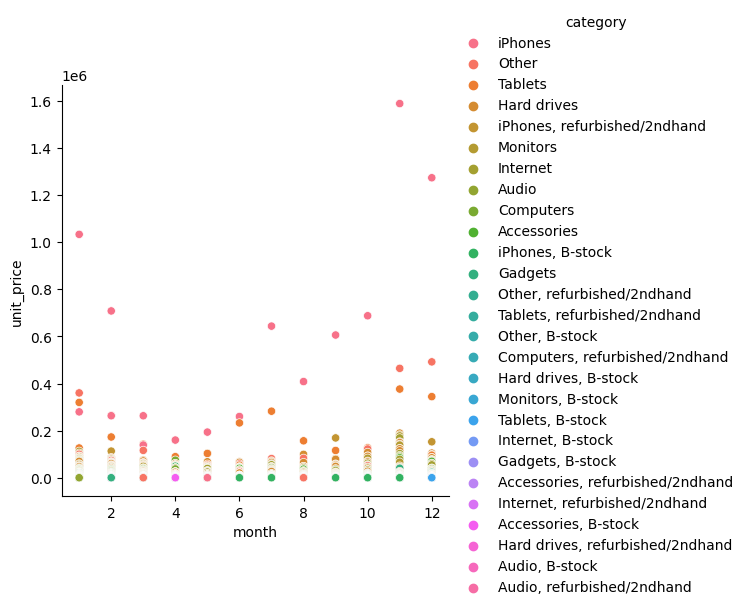

In [524]:
sns.relplot(data=plot,
            x="month", 
            y="unit_price",
           hue='category');

In [525]:
(
    ordlp
    .groupby("category")["product_quantity"]
    .sum()
    .sort_values(ascending=False)
)

category
Hard drives                         56227
Other                               48673
Accessories                         40968
iPhones                             32974
Gadgets                             15330
Audio                               12632
Tablets                             11391
Internet                            10175
Monitors                             7092
iPhones, B-stock                     2363
iPhones, refurbished/2ndhand         1798
Computers                            1463
Hard drives, B-stock                  576
Other, refurbished/2ndhand            499
Accessories, B-stock                  269
Accessories, refurbished/2ndhand      235
Tablets, refurbished/2ndhand          151
Other, B-stock                        117
Internet, B-stock                     101
Internet, refurbished/2ndhand         100
Gadgets, B-stock                       93
Monitors, B-stock                      88
Tablets, B-stock                       56
Computers, refurbished/2n

In [526]:
(
    ordlp
    .groupby(["brand", 'year'])
    .agg({"product_quantity": ["sum", "count"], "unit_price": ["sum", "mean"], 'price' : 'mean'})
    .nlargest(10, ("product_quantity", "sum"))
)

product_quantity          unit_price                   price
                        sum  count          sum        mean        mean
brand year                                                             
APP   2017            43037  38196  11688405.46  306.011244  321.965401
      2018            11598  11002   3745671.29  340.453671  371.129321
OWC   2017             9660   8586   1133636.33  132.033116  166.437466
WDT   2017             7845   5809    902380.81  155.341851  185.640923
CRU   2017             6702   5553    764113.77  137.603776  147.675568
PAC   2017             6651   5940   1906578.23  320.972766  452.066835
WAC   2017             5852   5342    840932.79  157.419092  197.829528
BEL   2017             5676   5273    155859.32   29.557997   41.162084
LAC   2017             5517   4879   1042493.76  213.669555  234.067918
SAN   2017             4809   3812    169094.30   44.358421   49.646249

In [527]:
(
    ordlp
    .groupby(["category", 'month'])
    .agg({"product_quantity": ["sum"], "unit_price": ["sum", 'mean'], 'price' : 'mean'})
    .nlargest(10, ("product_quantity", "sum"))
)

product_quantity  unit_price                   price
                               sum         sum        mean        mean
category    month                                                     
Other       1                 9294   692105.03   80.188278   94.568206
Hard drives 1                 9187  1069941.28  141.695309  165.109331
Accessories 1                 8818   365675.55   45.956460   60.898386
Hard drives 2                 7177   895068.91  150.381201  174.488553
            11                6874   904858.95  160.010424  188.855993
Other       11                6360   638360.57  109.948427  132.887623
            2                 6147   518962.32   90.443067  106.988423
iPhones     11                5786  1638315.60  301.826750  323.573112
Accessories 2                 5469   229872.87   47.406243   61.500501
iPhones     1                 5468  1373235.08  271.712521  283.030198

In [529]:
freq99 = ordlp.loc[ordlp['category'].isin(['iPhones','Accesories', 'Other', 'Hard drives', 'Computers', 'Internet', 'Tablets', 'Monitors', 'Audio', 'Gadgets'])][['sku', 'price', 'unit_price', 'product_quantity', 'month', 'category']].groupby(['month', 'price', 'category']).agg({'unit_price' : 'sum', 'product_quantity' : 'sum'})

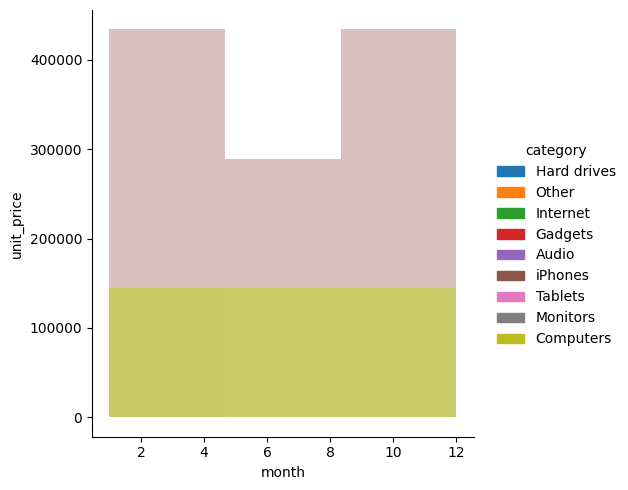

In [530]:
sns.displot(data=freq99, 
            x="month", 
            y = 'unit_price',
            hue="category", 
            bins=3, 
            )

In [531]:
(
    ordlp
    .groupby(["sku", 'category', 'month'])
    .agg({"product_quantity": ["sum"], "unit_price": ["sum"], 'discount' : 'sum'})
    .nlargest(100, ("unit_price", "sum")).head(10)
)

product_quantity unit_price  discount
                                    sum        sum       sum
sku     category month                                      
APP2485 iPhones  11                 238  203363.65   8006.35
                 12                 190  167643.51   5128.49
                 1                  178  157780.86   5801.14
APP2446 iPhones  7                  419  157436.35  24542.30
APP2477 iPhones  11                 206  153211.84   5352.16
APP2483 iPhones  11                 164  140246.91   4955.09
APP2477 iPhones  12                 179  131497.36   5223.64
APP2483 iPhones  12                 146  124224.76   4435.24
APP2072 Other    2                  128  123695.66  17819.86
                 12                 128  123152.81  17257.12

In [532]:
(
    ordlp
    .groupby(["sku", 'category'])
    .agg({"product_quantity": ["sum"], "unit_price": ["sum"], 'discount' : 'sum'})
    .nlargest(100, ("unit_price", "sum")).head(10)
)

,,product_quantity,unit_price,discount
,,sum,sum,sum
sku,category,,,
APP2485,iPhones,842,734093.81,23162.19
APP2477,iPhones,749,560061.80,18373.20
APP2483,iPhones,611,521304.78,16310.22
APP2072,Other,491,471162.93,67259.40
APP1970,iPhones,1181,365150.88,56363.12
APP2479,iPhones,471,360124.05,10397.95
APP2484,iPhones,401,349190.56,10138.44
APP2446,iPhones,969,348232.31,55715.36


In [533]:
temp2 = ordlp.loc[(ordlp['sku'].isin(['APP2485', 'APP2477', 'APP2499', 'APP1190', 'APP0698', 'APP2478', 'LGE0044', 'WDT0183', 'CRU0051'])&(ordlp['date'].dt.month == 12))][['brand', 'price', 'unit_price', 'year', 'product_quantity', 'month', 'sku']].groupby(['brand', 'sku', 'year', 'price']).agg({'unit_price' : 'mean', 'product_quantity' : 'sum'})

In [534]:
temp2 = temp2.reset_index(level='price')
temp2['discount'] = (1 - temp2['unit_price'] / temp2['price']) *100
temp2.sort_values(by='unit_price', ascending =False)

price  unit_price  product_quantity   discount
brand sku     year                                                 
APP   APP2485 2017  919.00  891.720798               190   2.968357
      APP2477 2017  809.00  778.090888               179   3.820657
      APP2478 2017  809.00  759.129072               101   6.164515
LGE   LGE0044 2017  599.00  575.381220                43   3.943035
APP   APP2499 2017  369.00  350.456496               138   5.025340
CRU   CRU0051 2017  158.66  129.872590               165  18.144088
WDT   WDT0183 2017  169.00  129.824924               214  23.180518
APP   APP1190 2017   70.00   56.959783               549  18.628882
      APP0698 2017   25.00    9.679655                46  61.281379

In [535]:
temp3 = ordlp.loc[ordlp['category'].isin(['iPhones','Accesories', 'Other', 'Hard drives', 'Computers', 'Internet', 'Tablets', 'Monitors', 'Audio', 'Gadgets'])&(ordlp['date'].dt.month == 11)][['brand', 'price', 'unit_price', 'year', 'product_quantity', 'month', 'sku', 'category']].groupby(['category', 'sku', 'year', 'price']).agg({'unit_price' : 'mean', 'product_quantity' : 'sum'})

In [536]:
temp3 = temp3.reset_index(level='price')
temp3['discount'] = (1 - temp3['unit_price'] / temp3['price']) *100
temp3.sort_values(by='product_quantity', ascending =False).head(10)

price  unit_price  product_quantity   discount
category    sku     year                                                 
Other       APP1190 2017   70.00   53.025020              1078  24.249972
Audio       APP1922 2017  179.00  155.479196               621  13.140114
Hard drives WDT0183 2017  169.00  132.866473               339  21.380785
iPhones     APP1970 2017  419.00  354.291503               305  15.443555
Hard drives CRU0051 2017  158.66  127.202236               268  19.827155
            CRU0050 2017   98.39   79.952737               262  18.738960
iPhones     APP2485 2017  919.00  884.189783               238   3.787836
Gadgets     NEA0009 2017  179.00  130.444148               238  27.126174
Other       APP0698 2017   25.00    9.267333               225  62.930667
Audio       PLA0027 2017  129.99   70.208186               220  45.989548

In [537]:
temp4 = ordlp.loc[ordlp['category'].isin(['iPhones','Accesories', 'Other', 'Hard drives', 'Computers', 'Internet', 'Tablets', 'Monitors', 'Audio', 'Gadgets'])&(ordlp['date'].dt.month == 7)][['brand', 'price', 'unit_price', 'year', 'product_quantity', 'month', 'sku', 'category']].groupby(['category', 'sku', 'year', 'price']).agg({'unit_price' : 'sum', 'product_quantity' : 'sum'})

In [538]:
temp4 = temp4.reset_index(level='price')
temp4['discount'] = (1 - temp4['unit_price'] / (temp4['price']* temp4['product_quantity'])) *100
temp4.sort_values(by='unit_price', ascending =False).head(10)

price  unit_price  product_quantity   discount
category sku     year                                                  
iPhones  APP2446 2017   449.33   157436.35               419  16.377033
         APP1970 2017   419.00    86615.37               259  20.185614
Tablets  APP2124 2017   899.00    43696.65                55  11.625746
iPhones  APP1972 2017   419.00    43137.12               121  14.915245
         APP1966 2017   419.00    41439.40               119  16.890155
Tablets  APP2131 2017  1059.00    36877.93                40  12.941619
iPhones  APP1971 2017   529.00    32367.65                71  13.821854
Tablets  APP1978 2017   402.81    30279.86                83   9.431844
iPhones  APP1648 2017   749.00    24689.65                30  -9.878282
         APP1968 2017   419.00    24657.48                68  13.458234

In [539]:
products.loc[products['sku'] == 'APP1190']

,sku,name,desc,price,in_stock,type,category,state,price category
3150,APP1190,IPhone AppleCare Protection Plan,Apple Care extended warranty iPhone.,70.0,1,1231,Other,New,Low


In [540]:
temp5 = ordlp.loc[ordlp['category'].isin(['iPhones','Accesories', 'Other', 'Hard drives', 'Computers', 'Internet', 'Tablets', 'Monitors', 'Audio', 'Gadgets'])][['brand', 'price', 'unit_price', 'year', 'product_quantity', 'month', 'sku', 'category']].groupby(['category', 'sku', 'year', 'month', 'price']).agg({'unit_price' : 'mean', 'product_quantity' : 'sum'})

In [541]:
temp5 = temp5.reset_index(level = 'price')
temp5['discount'] = (1 - temp5['unit_price'] / (temp5['price']* temp5['product_quantity'])) *100
pricetime =temp5.sort_values(by='unit_price', ascending =False).copy